In [29]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


In [30]:
train = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Train_Dataset.csv")
test = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Test_Dataset.csv")
val = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Val_Dataset.csv")
print(train)
print(test)
print(val)

                                                    text    label
0      On days when I feel close to my partner and ot...      joy
1      Every time I imagine that someone I love or I ...     fear
2      When I had been obviously unjustly treated and...    anger
3      When I think about the short time that we live...  sadness
4      After my girlfriend had taken her exam we went...      joy
...                                                  ...      ...
19458  i just had a very brief time in the beanbag an...        0
19459  i am now turning and i feel pathetic that i am...        0
19460                     i feel strong and good overall        1
19461  i feel like this was such a rude comment and i...        3
19462  i know a lot but i feel so stupid because i ca...        0

[19463 rows x 2 columns]
                                                   text    label
0                 South Korea cheating for gold medals.    anger
1     My friend has to go on field trips, he just to

In [31]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    labels = labels.replace(["0","1","2","3","4","5"],['sadness','joy','love','anger','fear','surprise'])
    return tweets, labels

In [32]:
tweets, labels = get_tweet(train)

In [33]:
print(labels)

0            joy
1           fear
2          anger
3        sadness
4            joy
          ...   
19458    sadness
19459    sadness
19460        joy
19461      anger
19462    sadness
Name: label, Length: 19463, dtype: object


In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [35]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [36]:
tokenizer.texts_to_sequences([tweets[1]])

[[168, 45, 2, 946, 10, 136, 2, 89, 38, 2, 83, 1213, 7, 1241, 1145, 80, 344]]

In [37]:
import pickle

# # saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# # with open('tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)

In [38]:
tweets[1]

'Every time I imagine that someone I love or I could contact a serious illness, even death.'

<function matplotlib.pyplot.show(close=None, block=None)>

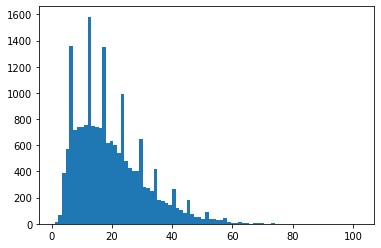

In [39]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [40]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [42]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [43]:
padded_train_seq

array([[ 30, 157,  17, ...,   0,   0,   0],
       [168,  45,   2, ...,   0,   0,   0],
       [ 17,   2,  32, ...,   0,   0,   0],
       ...,
       [  2,   4, 370, ...,   0,   0,   0],
       [  2,   4,  18, ...,   0,   0,   0],
       [  2,  53,   7, ...,   0,   0,   0]])

In [44]:
classes = set(labels)
print(classes)

{'surprise', 'anger', 'love', 'joy', 'fear', 'sadness'}


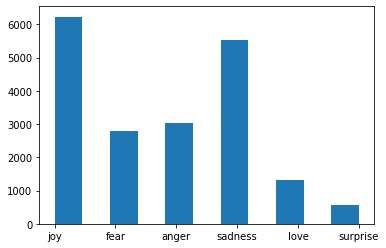

In [45]:
plt.hist(labels, bins=11)
plt.show()

In [46]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [47]:
class_to_index

{'surprise': 0, 'anger': 1, 'love': 2, 'joy': 3, 'fear': 4, 'sadness': 5}

In [48]:
index_to_class

{0: 'surprise', 1: 'anger', 2: 'love', 3: 'joy', 4: 'fear', 5: 'sadness'}

In [49]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [50]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


In [51]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
#         tf.keras.layers.Dropout(.25, input_shape=(2,)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_2/forward_lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
model.summary()

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_=model.evaluate(val_seq, val_labels)

In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

In [ ]:
preds = np.argmax(model.predict(test_seq), axis=-1)

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))

In [ ]:
from datetime import datetime
model.save("C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/SA_Model_Final_{}".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")))